### PCA 진행하기

In [2]:
from tensorflow import keras

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.1))
history = autoencoder.fit(X_train, X_train, epochs=20)
codings = encoder.predict(X_train)

C:\Users\Owner\Anaconda3\envs\tfgpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


NameError: name 'X_train' is not defined

### 적층 오토 인코더
- 적층 오토인코더의 구조는 가운데 은닉층(코딩 층)을 기준으로 대칭입니다. 

In [46]:
import tensorflow as tf

# 1. Fashion MNIST 데이터셋 불러오기
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_valid, y_valid) = fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_valid = X_valid.astype('float32') / 255.

In [47]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu'),
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.SGD(learning_rate=1.0))

history = stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))


Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3409 - val_loss: 0.3139
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3074 - val_loss: 0.3058
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3012 - val_loss: 0.3004
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2971 - val_loss: 0.2978
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2937 - val_loss: 0.2938
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2912 - val_loss: 0.2927
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2893 - val_loss: 0.2901
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2880 - val_loss: 0.2891
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2869 - val_loss: 0.2887
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.286

In [6]:
import matplotlib.pyplot as plt

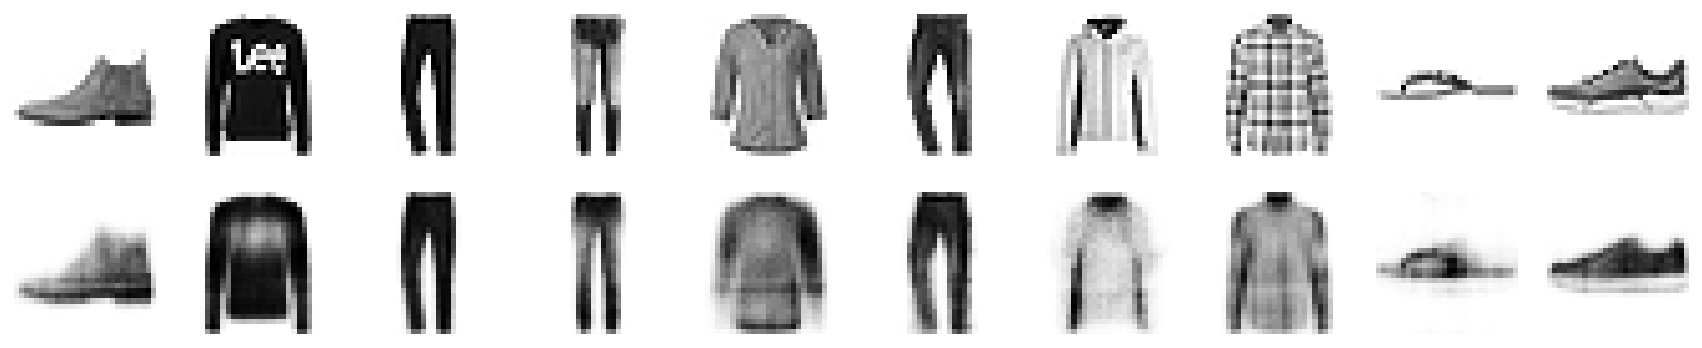

In [48]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
def show_reconstructions(model, n_images=10):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images*1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1+image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
show_reconstructions(stacked_ae)

In [50]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)


C:\Users\Owner\Anaconda3\envs\tfgpu\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\Owner\Anaconda3\envs\tfgpu\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


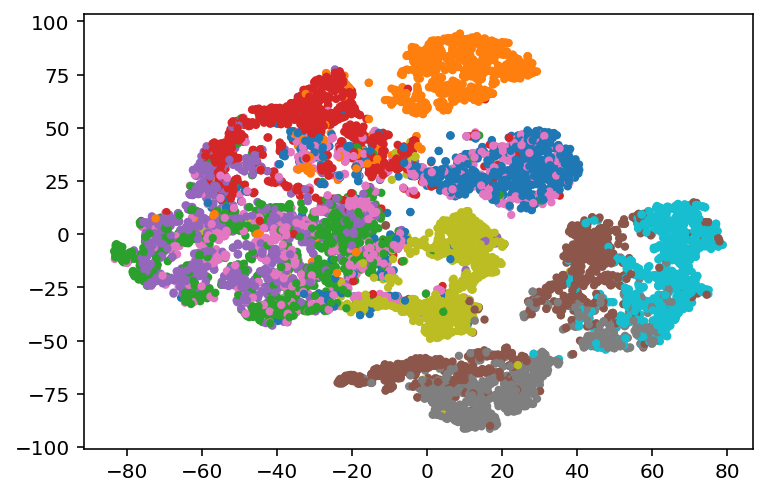

In [52]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10')
plt.show()

### 가중치 묶기

In [53]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
        
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias', initializer='zeros', shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b= True) # transpose_b 전치행렬 만들기
        return self.activation(z + self.biases)

In [ ]:
dense_1  = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.model.Sequentail([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequentail([tied_encoder, tied_decoder])




### 이미지를 오토인코더
- 성능이 안좋음


In [ ]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    
])


